## Introduction
This is adjust from the `test2.ipynb`, which is used to proof that the specific column of the Pearson's covariance matrix can be calculated column by column from $x$. 

#### Formula
Assume $X$ is an centered O/E matrix, $std$ is the standard deviation of $X$, $n$ is the length of $X[0]$.

* Covariance matrix: $\frac{1}{n}X X^{T}$
* Pearson matrix: $\frac{1}{std} \frac{1}{n}X X^{T}$
* The Covariance matrix of the Pearson matrix: $\frac{1}{n} (\frac{1}{std} \frac{1}{n}X X^{T} - C)(\frac{1}{std} \frac{1}{n}X X^{T}  - C)^{T}$, where the $C$ is the mean of the Pearson matrix.

In [286]:
import numpy as np
from hicpap import paptools
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)
np.set_printoptions(threshold=10)
# np.random.seed(3)

def flip_tracks(track1_np: np.ndarray, track2_np: np.ndarray):
    if np.corrcoef(track1_np[~np.isnan(track1_np)], track2_np[~np.isnan(track2_np)])[0][1] < 0:
        track2_np = -track2_np

    return track1_np, track2_np

Simulated Sample

In [287]:
def generate_X(n:int):
    # Create a nxn array with random positive values
    matrix_np = np.abs(np.random.randn(n, n))  # Use absolute values for positive entries
    # Make the array symmetric
    matrix_np = matrix_np + matrix_np.T
    matrix_np = matrix_np.astype("float64") # Sparse
    return matrix_np 

X = generate_X(n=30) # Generate a 5*5 simulated O/E matrix.
X -= X.mean(axis=1, keepdims=True) # Center the X.
n = len(X[0])
std = np.std(X, axis=1)
std = np.array([std]).flatten()

corr = np.corrcoef(X)
corr -= corr.mean(axis=1, keepdims=True)
corr_cov = np.cov(corr, bias=True)

pca = PCA(n_components=1)
pca.fit(np.corrcoef(X))
pc1_np = pca.components_[0]

print(corr_cov, '\n')
print(f"Explained variance ratio of the PC1: {pca.explained_variance_[0]}")

[[ 0.06667 -0.02    -0.0027  ...  0.01746  0.02129 -0.0347 ]
 [-0.02     0.06895  0.01218 ...  0.0101  -0.00788  0.02816]
 [-0.0027   0.01218  0.06544 ... -0.00729 -0.01274  0.01614]
 ...
 [ 0.01746  0.0101  -0.00729 ...  0.05631  0.01204 -0.01318]
 [ 0.02129 -0.00788 -0.01274 ...  0.01204  0.05318 -0.01876]
 [-0.0347   0.02816  0.01614 ... -0.01318 -0.01876  0.06262]] 

Explained variance ratio of the PC1: 0.49213706520250444


In [288]:
index_s = 0 # The target column (or row) in the Pearson's covariance matrix.
corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
corr_s -= corr_s.mean()
print(corr_s, '\n')

[ 1.00841 -0.15906  0.00708 ...  0.13575  0.11169 -0.34284] 



In [289]:
cov_s = []

for i in range(n):
    corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
    corr_i -= corr_i.mean()
    entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
    cov_s.append(entry)

cov_s = np.array(cov_s)

# Finally, these two variables should be exactly the same.
print(corr_cov[index_s], '\n')
print(cov_s, '\n')

[ 0.06667 -0.02    -0.0027  ...  0.01746  0.02129 -0.0347 ] 

[ 0.06667 -0.02    -0.0027  ...  0.01746  0.02129 -0.0347 ] 



Find the best track and plot

In [290]:
max = 0
approx_np = np.array([]) 

for k in range(n):
    index_s = k # The target column (or row) in the Pearson's covariance matrix.
    corr_s = (X @ X[index_s].T / (std[index_s] * std)) / n # The target column (or row) in the Pearson matrix.
    corr_s -= corr_s.mean()
    cov_s = []

    for i in range(n):
        corr_i = (X @ X[i].T / (std[i] * std)) / n # Calculate the other columns in the Pearson matrix one by one. 
        corr_i -= corr_i.mean()
        entry = corr_i @ corr_s / n # Calculate each entry of the target column (or row) in the Pearson's covariance matrix.
        cov_s.append(entry)

    cov_s = np.array(cov_s)
    if np.sum(np.abs(cov_s)) > max:
        max = np.sum(np.abs(cov_s))
        approx_np = cov_s

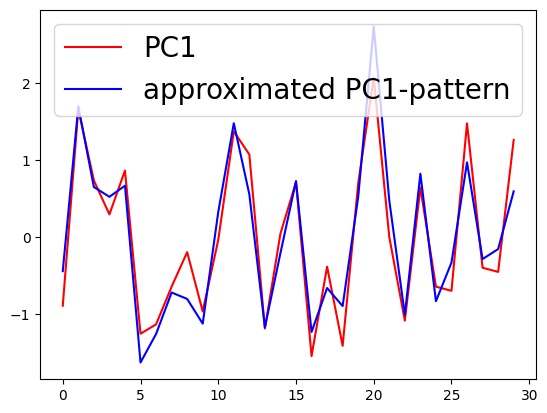

In [291]:
from matplotlib import pyplot as plt

pc1_np, approx_np = flip_tracks(track1_np=pc1_np, track2_np=approx_np)
similarity_info = paptools.calc_similarity(track1_np=pc1_np, track2_np=approx_np)
total_entry_num = similarity_info["total_entry_num"]
valid_entry_num = similarity_info["valid_entry_num"]
similar_num = similarity_info["similar_num"]
similar_rate = similarity_info["similar_rate"]

# Z-score Normalization
approx_np_norm = (approx_np - np.mean(approx_np)) / np.std(approx_np)
pc1_np_norm = (pc1_np - np.mean(pc1_np)) / np.std(pc1_np)

plt.plot(pc1_np_norm, c='r')
plt.plot(approx_np_norm, c='b')
plt.legend(["PC1", "approximated PC1-pattern"], fontsize="20", loc ="upper left")